In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
# %matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')##出現提示欄進行授權
os.chdir('/content/drive/My Drive/Colab Notebooks/kaggle-sklearn') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['libs',
 'sklearn_regression.ipynb',
 'data',
 'sklearn_classifier.ipynb',
 'classifier_heart_failure.ipynb']

In [32]:
df_set = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

In [33]:
TARGET='DEATH_EVENT'

df_feature=df_set.drop(columns=[TARGET])
df_target=df_set[TARGET]
df=pd.concat([df_feature,df_target],axis=1)
print(df.head())

    age  anaemia  creatinine_phosphokinase  ...  smoking  time  DEATH_EVENT
0  75.0        0                       582  ...        0     4            1
1  55.0        0                      7861  ...        0     6            1
2  65.0        0                       146  ...        1     7            1
3  50.0        1                       111  ...        0     7            1
4  65.0        1                       160  ...        0     8            1

[5 rows x 13 columns]


## Analysis

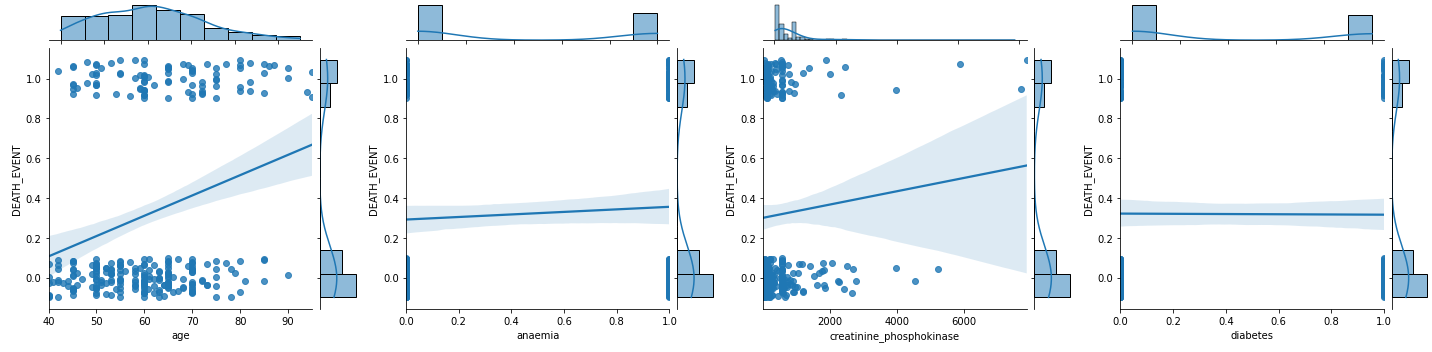

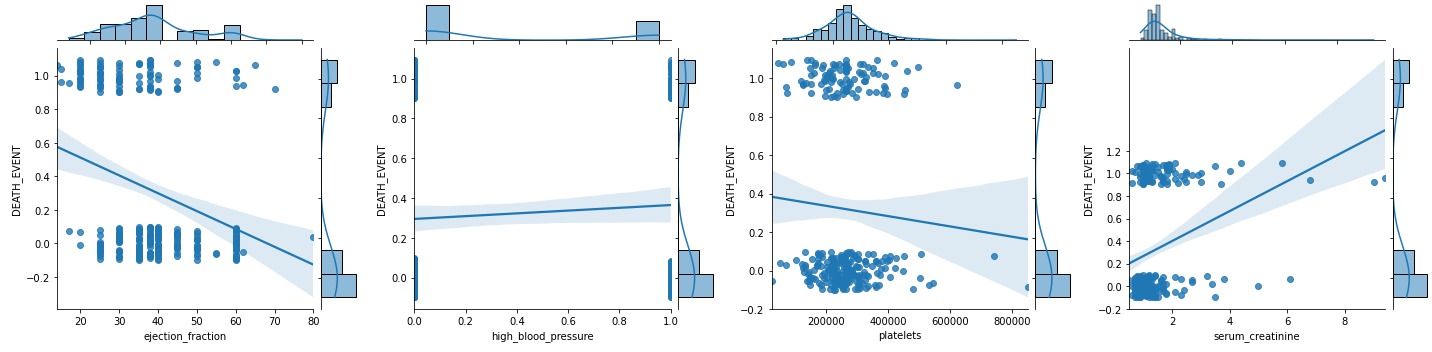

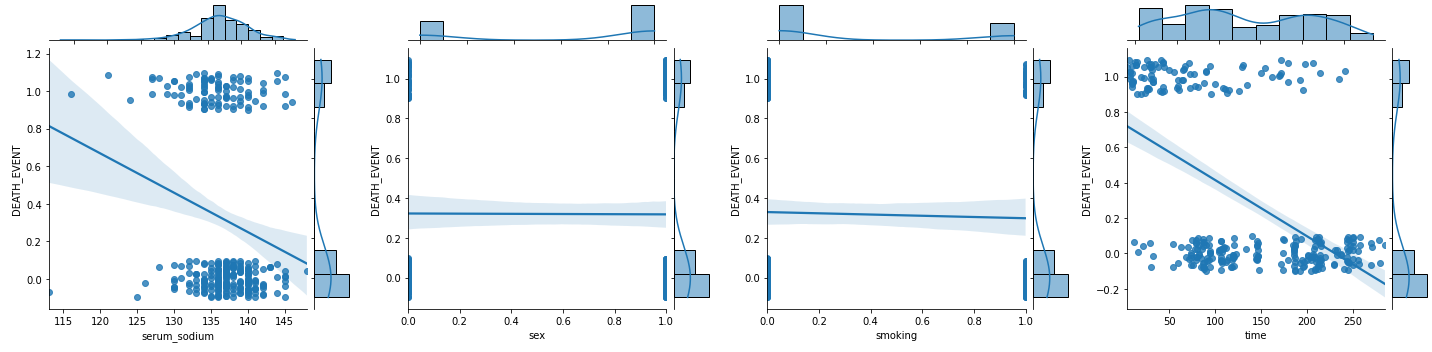

In [19]:
from libs.SeabornFig2Grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
#增強資料可視性
lst_tmp=[]
for i in range(len(df)):
  lst_tmp.append(random.uniform(-0.1,0.1))
df_plt=df.copy()
df_plt[TARGET]=df[TARGET]+lst_tmp
#繪製
for i in range(math.ceil(len(df_feature.columns)/4)):
  fig=plt.figure(figsize=(20,5))
  gs=gridspec.GridSpec(1, 4)
  for j in range(4):
    try:
      fig_tmp=sns.jointplot(x=list(df_feature)[(4*i+j)],y=TARGET,data=df_plt,kind='reg')
      mg=SeabornFig2Grid(fig_tmp, fig, gs[j])
    except IndexError:
      continue     
  gs.tight_layout(fig)
  plt.show()



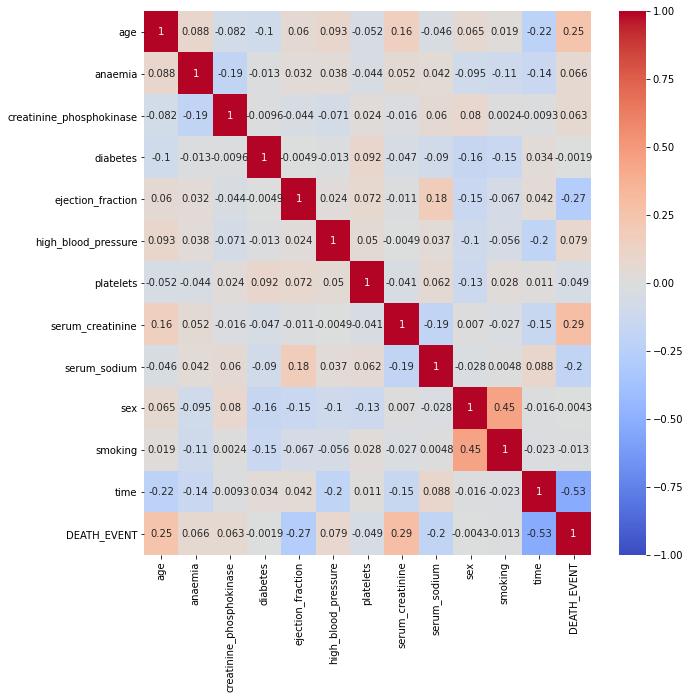

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', annot=True)

## Feature Select

In [35]:
df=df[['ejection_fraction','serum_creatinine','time',TARGET]]
print(df.head())

   ejection_fraction  serum_creatinine  time  DEATH_EVENT
0                 20               1.9     4            1
1                 38               1.1     6            1
2                 20               1.3     7            1
3                 20               1.9     7            1
4                 20               2.7     8            1


## Training Prepare

In [36]:
#Training set & Testing set
X=df[df.columns[:-1]].values
Y=df[df.columns[-1]].values
train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.2, random_state=0)
X.mean()
#StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(train_X)
train_X_std=sc.transform(train_X)
test_X_std=sc.transform(test_X)

In [48]:
def training(method):
  classifier = method
  classifier.fit(train_X, train_Y)
  print(classifier.fit(train_X, train_Y))

  pred_Y = classifier.predict(test_X)
  test_prob=np.ravel(classifier.predict_proba(test_X)[:,[1]])
  df_pred = pd.DataFrame({'Actual': test_Y, 'Predicted': pred_Y,'Probability':test_prob}).round(3)
  df_pred['Error']=df_pred['Predicted']-df_pred['Actual']
  df_pred=df_pred.sort_values(by='Actual').reset_index(drop=True)
  max_value=max([df_pred['Actual'].max(),df_pred['Predicted'].max()])

  #plot
  plt.figure(figsize=(25,3))
  plt.bar(df_pred.index,df_pred['Probability'],width=0.5,zorder=1)
  plt.bar(df_pred[df_pred['Error']!=0].index,df_pred[df_pred['Error']!=0]['Probability'],width=0.5,zorder=1,color='r')
  plt.scatter(df_pred.index,df_pred['Predicted'],c='r',s=12,zorder=3)
  plt.scatter(df_pred.index,df_pred['Actual'],zorder=2,c='g')
  plt.xticks(df_pred.index,df_pred['Probability'].round(3),rotation=90)
  plt.legend(['predict','actual','prob','Predict_error prob'])
  plt.grid() 
  plt.show()
   
  print('Accuracy Score:', round(metrics.accuracy_score(test_Y,pred_Y,normalize=True),4))

## Training

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


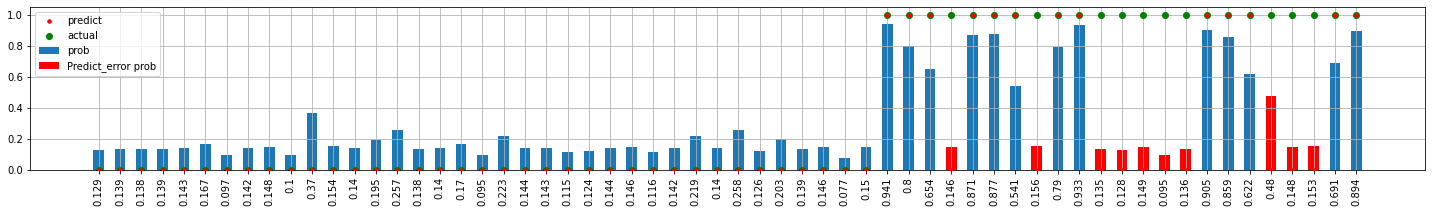

Accuracy Score: 0.8333


In [49]:
from sklearn.svm import SVC
training(SVC(probability=True))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


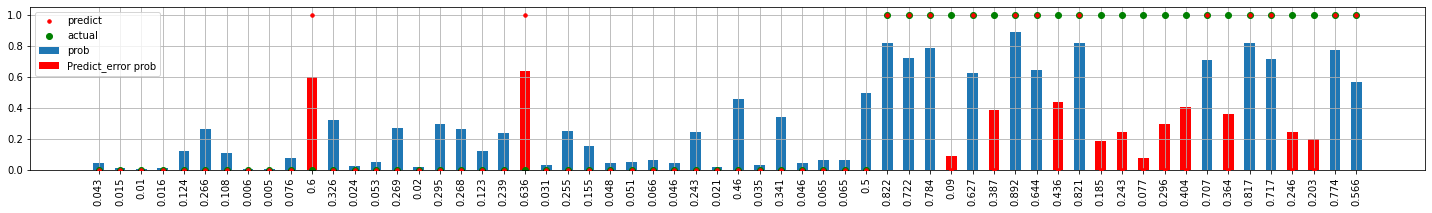

Accuracy Score: 0.7833


In [50]:
from sklearn.linear_model import LogisticRegression
training(LogisticRegression())

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


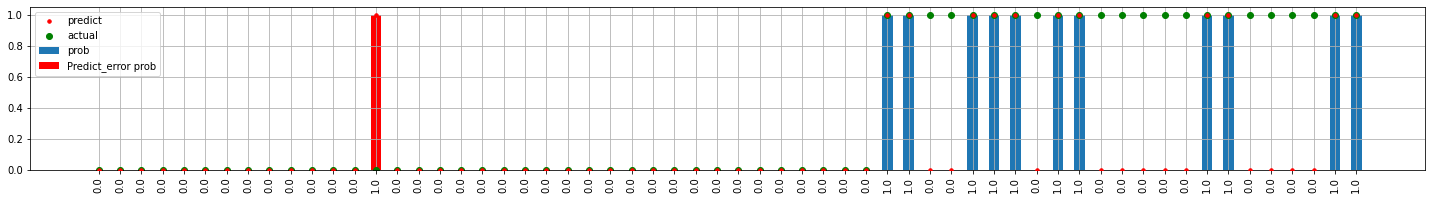

Accuracy Score: 0.7833


In [51]:
from sklearn.linear_model import SGDClassifier
training(SGDClassifier(loss='modified_huber'))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


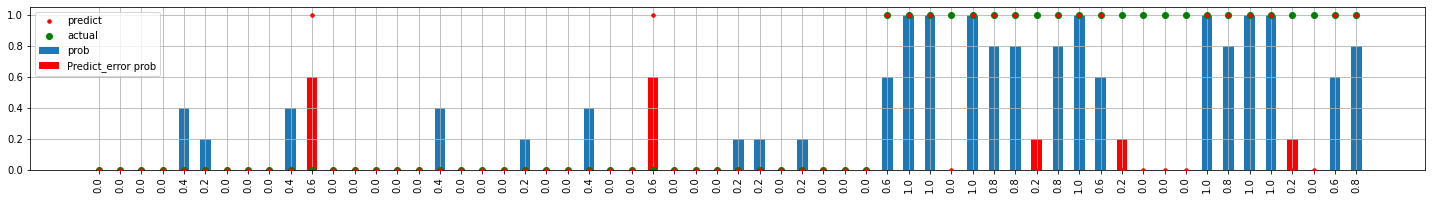

Accuracy Score: 0.8333


In [52]:
from sklearn.neighbors import KNeighborsClassifier
training(KNeighborsClassifier())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


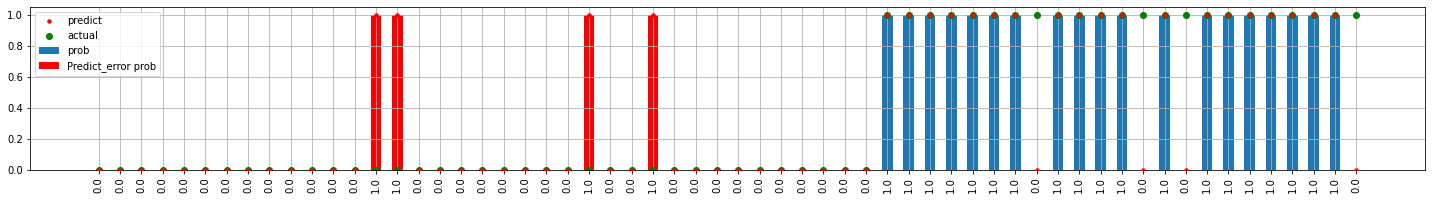

Accuracy Score: 0.8667


In [53]:
from sklearn.tree import DecisionTreeClassifier
training(DecisionTreeClassifier())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


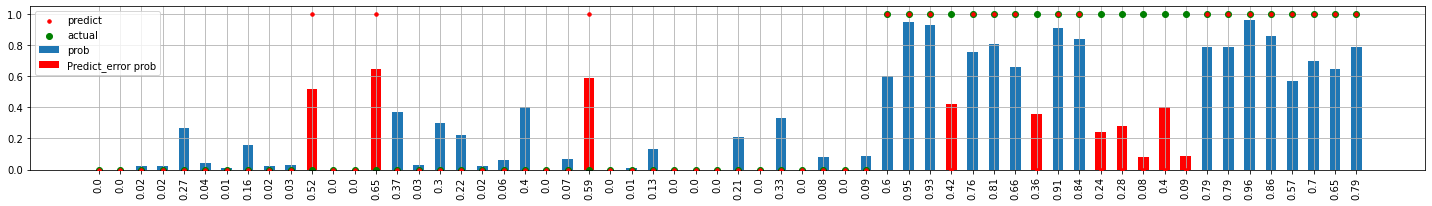

Accuracy Score: 0.8333


In [54]:
from sklearn.ensemble import RandomForestClassifier
training(RandomForestClassifier())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


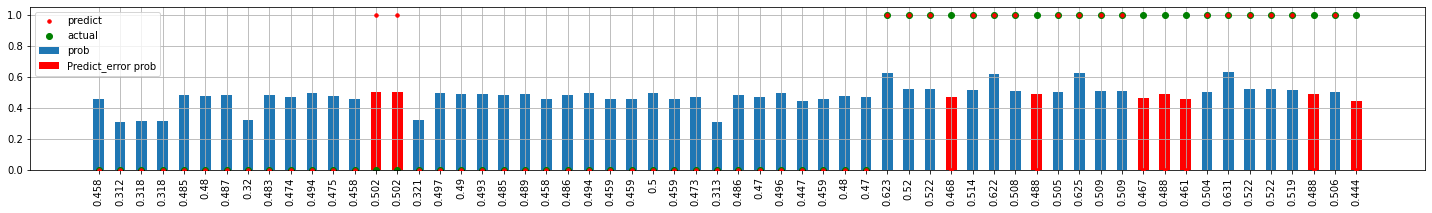

Accuracy Score: 0.85


In [55]:
from sklearn.ensemble import AdaBoostClassifier
training(AdaBoostClassifier())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


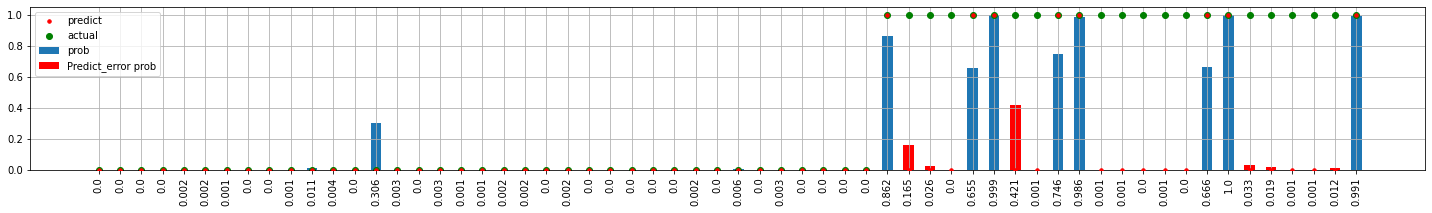

Accuracy Score: 0.75


In [56]:
from sklearn.neural_network import MLPClassifier
training(MLPClassifier())

Learning rate set to 0.005591
0:	learn: 0.6883020	total: 1.51ms	remaining: 1.51s
1:	learn: 0.6831448	total: 3.46ms	remaining: 1.73s
2:	learn: 0.6778358	total: 4.15ms	remaining: 1.38s
3:	learn: 0.6734255	total: 4.82ms	remaining: 1.2s
4:	learn: 0.6690686	total: 5.49ms	remaining: 1.09s
5:	learn: 0.6652836	total: 5.96ms	remaining: 988ms
6:	learn: 0.6610327	total: 6.65ms	remaining: 944ms
7:	learn: 0.6573734	total: 7.28ms	remaining: 903ms
8:	learn: 0.6537501	total: 7.92ms	remaining: 872ms
9:	learn: 0.6491198	total: 8.6ms	remaining: 851ms
10:	learn: 0.6447842	total: 9.27ms	remaining: 833ms
11:	learn: 0.6396574	total: 9.95ms	remaining: 820ms
12:	learn: 0.6355522	total: 10.6ms	remaining: 806ms
13:	learn: 0.6309052	total: 11.3ms	remaining: 794ms
14:	learn: 0.6268028	total: 11.9ms	remaining: 783ms
15:	learn: 0.6236357	total: 12.4ms	remaining: 760ms
16:	learn: 0.6200697	total: 13.1ms	remaining: 755ms
17:	learn: 0.6165602	total: 13.7ms	remaining: 749ms
18:	learn: 0.6131796	total: 14.4ms	remaining: 

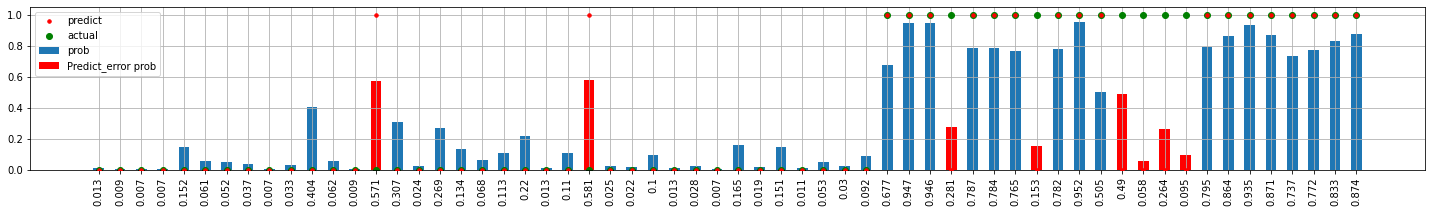

Accuracy Score: 0.8667


In [60]:
!pip install catboost
from catboost import CatBoostClassifier
training(CatBoostClassifier())